This is an exploration of X-ray image data obtained from https://github.com/paras42/Hello_World_Deep_Learning

We will do the following things:

- Preprocess the dataset to the correct format for Keras sequential models, including applying data augmentation 
- Apply PCA and visualise explained variance
- Use reduced dimensional data to train a sequential model and evaluate performance
- Visualise the data using TSNE and Hierarchical Clustering
- Apply transfer learning of Google's Inception V3 to the X-ray dataset and evaluate performance
- Produce sample augmented images and feature maps

In [1]:
from keras import backend

Using TensorFlow backend.


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Here I have imported the necessary modules to generate the image data and apply real-time augmentation

Code referenced in Methodology: Preprocessing 4.2, Dimensionality Reduction 4.3 and Keras Sequential Model 4.5

In [3]:
#Import necessary modules
import keras as K
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.regularizers import l1, l2
from keras import metrics
from keras.utils import plot_model
import pydot as pyd
from keras.applications.inception_v3 import InceptionV3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from numpy import concatenate
from PIL import Image 

# Dimensions of our images.
img_width, img_height = 299, 299

# Location of training data
train_data_dir = r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN"

# Location of validation data
validation_data_dir = r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\VAL"


# Number of samples used for determining the samples per epoch
nb_train_samples = 65
nb_validation_samples = 10
epochs = 20
batch_size = 5  

# Using ImageDataGenerator() to rescale images and apply real time augmentation
# Training data with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True) 

# Validation Data without augmentation 
val_datagen = ImageDataGenerator(
        rescale=1./255)       # normalize pixel values to [0,1]

# Producing batches of image data to be accepted by Keras Seqential Model using 'model.fit_generator()'
# Training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


PCA data preprocessing: see Dimensionality Reduction (Section 4.3)

Found 65 images belonging to 2 classes.


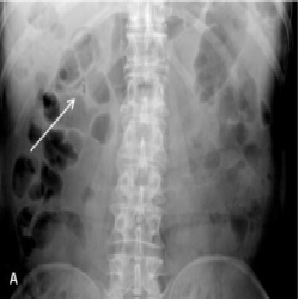

None
[1.]
(65, 299, 299, 3)
(10, 299, 299, 3)
(65, 268203)
(10, 268203)
(75, 268203)
(75,)


In [4]:
# Training data without augmentation (for use in PCA)
train_datagen2 = ImageDataGenerator(
        rescale=1./255)      # normalize pixel values to [0,1]

train_generator2 = train_datagen2.flow_from_directory(
    train_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

# Convert non-augmented training and validation data into numpy arrays for use in PCA
# Data is converted from train_generator using '.next()' method to iterate through batches of 5

# Produced in batches of 5 so range(13) produces 5x13 = 65 training images 
train_images = np.concatenate([train_generator2.next()[0] for i in range(13)])
train_labels2 = np.concatenate([train_generator2.next()[1] for i in range(13)])
train_labels = np.reshape(train_labels2,(65,1))

# range(2) produces 5x2 = 10 validation images
val_images = np.concatenate([validation_generator.next()[0] for i in range(2)])
val_labels2 = np.concatenate([validation_generator.next()[1] for i in range(2)])
val_labels = np.reshape(val_labels2,(10,1))

# Check images match up to label: not matching up correctly 
# However since data is produced from a generator it is combined correctly in sequential model
print(display(array_to_img(train_images[24])))
print(train_labels[24])

# Check shape of data
print(train_images.shape)
# (65, 299, 299, 3)
print(val_images.shape)
# (10, 299, 299, 3)

# Flatten the images in 2D vector using (65,299x299x3) = (65,268203)
train_images = np.reshape(train_images,(65,268203))
val_images = np.reshape(val_images,(10,268203))

# Check shape is correct
print(train_images.shape)
# (65, 268203)
print(val_images.shape)
# (10, 268203)

# Concatenate (combine) images and labels from both training and validation data 
# This is because with less that 75 images we need 23 PCs for 90% variance 
# and PCA cannot produce 23 PCs on 10 validation images so we produce 23 PCs on 75 combined images
images = np.concatenate((train_images,val_images))
labels = np.concatenate((train_labels2,val_labels2))

print(images.shape)
# (75, 268203)
print(labels.shape)
# (75,)

PCA exploration: see Dimensionality Reduction (Section 4.3)

PCA done! Time elapsed: 4.786104202270508 seconds
Variance explained per principal component: [0.35792947 0.09307069 0.08756027 0.06722938 0.04470514 0.0354409
 0.03251021 0.02894028 0.02251304 0.01800801 0.01567746 0.01442152
 0.01145865 0.01030641 0.00957111 0.00832105 0.007706   0.0075008
 0.00680107 0.00658206 0.0059962  0.00534516 0.00500809]
(75, 23)


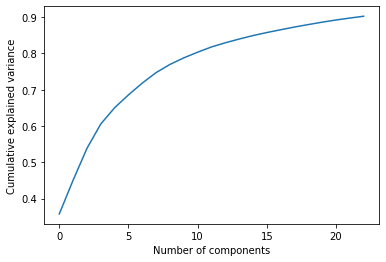

In [5]:
# Import PCA module from scikit learn and other used modules
from sklearn.decomposition import PCA
import os
import time

# Conducting PCA on numpy arrays of X-ray data
# Used 'n_components=0.9' to capture 90% of data variance which produces 23 Principal Components (eigenvectors)
# from combined dataset of 75 images
time_start = time.time()
pca = PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,  svd_solver='auto', tol=0.0, whiten=True)
pca.fit(images)
pca_images = pca.transform(images)

# Produce graph of cumulative explained variance from 23 PCs
# and print eigenvalues as 'Variance explained per principal component'
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

# Check tensor shape
print(pca_images.shape)
# (75,23)

Further PCA exploration: constructing Keras sequential model from pca_images: see Dimensionality Reduction (Section 4.3)

In [6]:
modelPCA = Sequential() 
# hidden layer 1
modelPCA.add(Dense(1024, activation='relu', input_shape=(23,)))
modelPCA.add(Dropout(0.25))
modelPCA.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# hidden layer 2
modelPCA.add(Dense(1024, activation='relu'))
modelPCA.add(Dropout(0.25))
modelPCA.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# hidden layer 3
modelPCA.add(Dense(512, activation='relu'))
# hidden layer 4
modelPCA.add(Dense(256, activation='relu'))
# output layer
modelPCA.add(Dense(1, activation='sigmoid')) #used ‘sigmoid’ for the output layer as this is a binary classification.

# compile using Adam optimisation algorithm
modelPCA.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='binary_crossentropy', metrics=['accuracy', metrics.mae])

# train PCA model (no validation used here as train and validation sets are combined)
historyPCA = modelPCA.fit(pca_images, labels,batch_size=batch_size,epochs=epochs,verbose=1,
                    validation_data=None)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





75/75 [==============================] - 5s 68ms/step - loss: 0.7341 - acc: 0.5067 - mean_absolute_error: 0.4916
Epoch 2/20
75/75 [==============================] - 1s 8ms/step - loss: 0.6980 - acc: 0.5467 - mean_absolute_error: 0.4718
Epoch 3/20
75/75 [==============================] - 1s 8ms/step - loss: 0.6411 - acc: 0.6533 - mean_absolute_error: 0.4445
Epoch 4/20
75/75 [==============================] - 1s 8ms/step - loss: 0.6032 - acc: 0.6667 - mean_absolute_error: 0.4246
Epoch 5/20
75/75 [==============================] - 1s 7ms/step - loss: 0.5732 - acc: 0.7067 - mean_absolute_error: 0.4043
Epoch 6/20
75/75 [==============================] - 1s 8ms/step - loss: 0.5137 - acc: 0.7467 - mean_absolute_error: 0.3735
Epoch 7/20
75/75 [====================

dict_keys(['loss', 'acc', 'mean_absolute_error'])


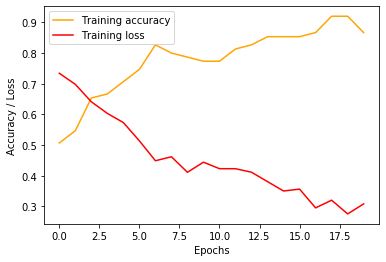

In [7]:
# Produce PCA performance graph
print(historyPCA.history.keys())
plt.figure()
plt.plot(historyPCA.history['acc'], 'orange', label='Training accuracy')
plt.plot(historyPCA.history['loss'], 'red', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

In [8]:
# Produce accuarcy measures
loss = modelPCA.evaluate(pca_images, labels)
print(modelPCA.metrics_names)
print(loss)
print("Accuracy = ", loss[1])

75/75 [==============================] - 1s 10ms/step
['loss', 'acc', 'mean_absolute_error']
[0.1237427282333374, 0.9733333325386048, 0.10409948388735453]
Accuracy =  0.9733333325386048


Visualisation

Produce TSNE visualisation of data: see Dimensionality Reduction (Section 4.3)

t-SNE done! Time elapsed: 3.105114459991455 seconds


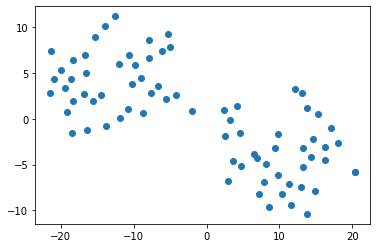

In [9]:
# Import TSNE from sckit learn
from sklearn.manifold import TSNE
time_start = time.time()

tsne_images = TSNE(perplexity=15,learning_rate=1).fit_transform(images)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_images.shape
x = [tsne[0] for tsne in tsne_images]
y = [tsne[1] for tsne in tsne_images]
plt.scatter(x,y)
# Graph produced shows clear seperation of data into clusters
# different 'perplexity' values produce different plots (some with less clear speration)

Producing dendrogram from X-ray data using hierarchical clustering: see Hierarchical Clustering (Section 3.6.1)

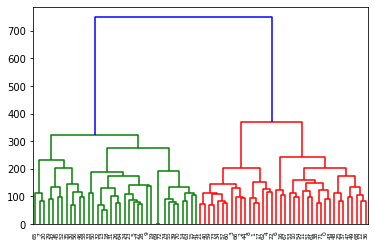

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(images, method='ward'))
#Looking at the dendrogram, the highest vertical distance that doesn’t intersect with any clusters is the top blue one.
#Given that 2 vertical lines cross the threshold, the optimal number of clusters is 2.

Full X-Ray binary classification model using Google's Inception V3 as source model: see Keras Sequential Model (Section 4.5)

In [11]:
source_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [12]:
# Check input and output shape of source model
print(source_model.input_shape[0:])
print(source_model.output_shape[0:])

(None, 299, 299, 3)
(None, 8, 8, 2048)


In [13]:
# Define sequential model
model_top = Sequential()
# hidden convolutional layer 1
model_top.add(Conv2D(16, (3, 3), input_shape=(8,8,2048), activation='relu', padding='valid'))
# hidden convolutional layer 2
model_top.add(Conv2D(16, (5, 5), activation='relu', padding='valid'))
model_top.add(GlobalMaxPooling2D(input_shape=(299, 299, 3), data_format=None))  
# hidden layer 3
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.25))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# hidden layer 4
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.25))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# output layer
model_top.add(Dense(1, activation='sigmoid')) #used ‘sigmoid’ for the output layer as this is a binary classification.

# Produce summary of model to be trained on X-ray data
model_top.summary()

# Combine with Inception V3 (source) model
model = Model(inputs=source_model.input, outputs=model_top(source_model.output))

# Produce summary of full model
model.summary()

# Compile using Adam optimisation algorithm 
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy', metrics.mae])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 6, 6, 16)          294928    
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 2, 2, 16)          6416      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4352      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
__________

In [14]:
# Train model on train and validation generators
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
13/13 [==============================] - 138s 11s/step - loss: 0.7790 - acc: 0.5538 - mean_absolute_error: 0.4644 - val_loss: 0.5733 - val_acc: 0.7000 - val_mean_absolute_error: 0.4076
Epoch 2/20
13/13 [==============================] - 71s 5s/step - loss: 0.5998 - acc: 0.7231 - mean_absolute_error: 0.3834 - val_loss: 0.7599 - val_acc: 0.9000 - val_mean_absolute_error: 0.3959
Epoch 3/20
13/13 [==============================] - 84s 6s/step - loss: 0.4768 - acc: 0.7692 - mean_absolute_error: 0.3205 - val_loss: 0.9757 - val_acc: 0.5000 - val_mean_absolute_error: 0.4527
Epoch 4/20
13/13 [==============================] - 63s 5s/step - loss: 0.5323 - acc: 0.7538 - mean_absolute_error: 0.3417 - val_loss: 0.4886 - val_acc: 0.9000 - val_mean_absolute_error: 0.3178
Epoch 5/20
13/13 [==============================] - 46s 4s/step - loss: 0.4369 - acc: 0.8462 - mean_absolute_error: 0.2633 - val_loss: 0.1366 - val_acc: 1.0000 - val_mean_absolute_error: 0.1241
Epoch 6/20
13/13 [==========

dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'loss', 'acc', 'mean_absolute_error'])


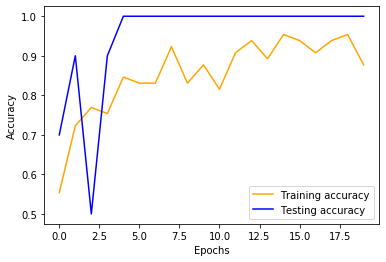

In [15]:
# Produce accuracy curve
print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

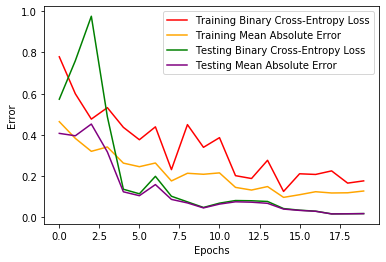

In [16]:
# Produce loss curve
plt.figure()
plt.plot(history.history['loss'], 'red', label='Training Binary Cross-Entropy Loss')
plt.plot(history.history['mean_absolute_error'], 'orange', label='Training Mean Absolute Error')
plt.plot(history.history['val_loss'], 'green', label='Testing Binary Cross-Entropy Loss')
plt.plot(history.history['val_mean_absolute_error'], 'purple', label='Testing Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

Testing model on individual images from test set and externally obtained images: see Model Evaluation (Section 5)

Images from test set (unseen by model)

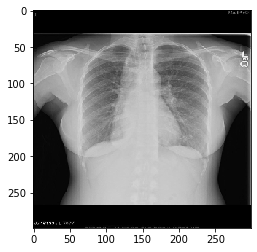

Predicted: [[0.15359496]] Chest X-ray


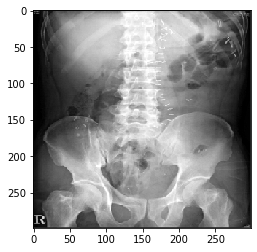

Predicted: [[0.9814487]] Abd X-ray


In [17]:
import numpy as np
from keras.preprocessing import image

# Image locations
img_path= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\chest2.png"
img_path2= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\abd2.png"

# Load images
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))

# Show image which is being classified: Chest X-ray
plt.imshow(img)
plt.show()

# Convert to array
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255     # normalize pixel values to [0,1]
# Use model to classify image
score = model.predict(x)
# Round scores to give qualitative classification of image
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

# Abdominal X-ray
plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')

Externally obtained images from: https://radiopaedia.org/cases/normal-chest-x-ray

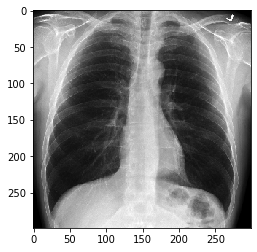

Predicted: [[0.00775027]] Chest X-ray


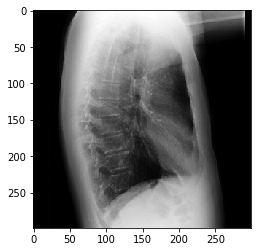

Predicted: [[0.40038335]] Chest X-ray


In [18]:
# Image locations
img_path= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\other\76052f7902246ff862f52f5d3cd9cd_jumbo.jpg"
img_path2= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\other\da9ebbb115dc5a6bc77a65541789eb_jumbo.jpg"

# Load images
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))

# Show image which is being classified: Chest X-ray
plt.imshow(img)
plt.show()

# Convert to array
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255     # normalize pixel values to [0,1]
# Use model to classify image
score = model.predict(x)
# Round scores to give qualitative classification of image
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

# Side view Chest X-ray
plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')


In [19]:
# Produce accuracy measures
loss = model.evaluate_generator(train_generator, len(train_generator),  workers = 1)
print(model.metrics_names)
print(loss)
print("Accuracy = ", loss[1])

['loss', 'acc', 'mean_absolute_error']
[0.05327731621666597, 1.0, 0.04817547104679621]
Accuracy =  1.0


In [20]:
# Produce confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

Y_pred = model.predict_generator(train_generator, 13)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))

Confusion Matrix
[[33  0]
 [32  0]]


Sample Augmented images shown in Preprocessing (Section 4.2: Figure 6)

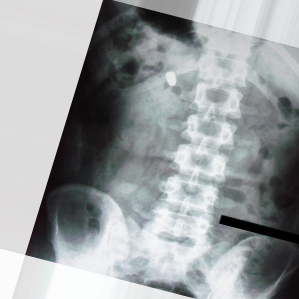

None


In [21]:
# Producing sample augmented images using '.next()' method and displaying transformed image
augmented_images = np.concatenate([train_generator.next()[0] for i in range(13)])
print(display(array_to_img(augmented_images[24])))

Feature maps shown in Convolutional Neural Network (Section 3.7.4: Figure 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
[[[ 32.  32.  32.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  7.   7.   7.]
  [  6.   6.   6.]
  [ 33.  33.  33.]]

 [[ 40.  40.  40.]
  [ 61.  61.  61.]
  [ 31.  31.  31.]
  ...
  [  4.   4.   4.]
  [  3.   3.   3.]
  [ 33.  33.  33.]]

 [[ 34.  34.  34.]
  [ 32.  32.  32.]
  [ 20.  20.  20.]
  ...
  [  4.   4.   4.]
  [  3.   3.   3.]
  [ 35.  35.  35.]]

 ...

 [[ 34.  34.  34.]
  [ 10.  10.  10.]
  [  4.   4.   4.]
  ...
  [ 81.  81.  81.]
  [123. 123. 123.]
  [ 44.  44.  44.]]

 [[ 33.  33.  33.]
  [  3.   3.   3.]
  [ 

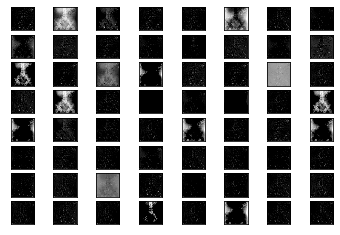

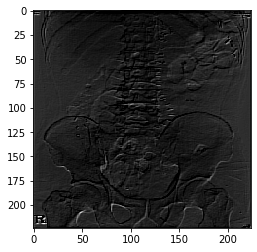

In [22]:
# producing feature maps from first convolutional layer for given image

# Import VGG16 model and produce feature maps
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape [(224,224) for VGG16 model]
img = load_img(r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\abd2.png", target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
print(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

# show individual feature maps
pyplot.imshow(feature_maps[0, :, :, 15], cmap='gray')